In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.fft import fft, ifft
from scipy.signal import hilbert
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.signal import hilbert
from scipy.fft import fft, ifft

In [2]:
CC_p1 = pd.read_excel('.\Latest_Augmented\CC_P1_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)
CC_p2 = pd.read_excel('.\Latest_Augmented\CC_P2_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)
CC_p3 = pd.read_excel('.\Latest_Augmented\CC_P3_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)

In [3]:
LFA_p1 = pd.read_excel('.\Latest_Augmented\LFA_P1_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)
LFA_p2 = pd.read_excel('.\Latest_Augmented\LFA_P2_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)
LFA_p3 = pd.read_excel('.\Latest_Augmented\LFA_P3_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)

In [4]:
TRF_p1 = pd.read_excel('.\Latest_Augmented\TRF_P1_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)
TRF_p2 = pd.read_excel('.\Latest_Augmented\TRF_P2_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)
TRF_p3 = pd.read_excel('.\Latest_Augmented\TRF_P3_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)

In [5]:
HDC_p1 = pd.read_excel('.\Latest_Augmented\HDC_P1_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)
HDC_p2 = pd.read_excel('.\Latest_Augmented\HDC_P2_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)
HDC_p3 = pd.read_excel('.\Latest_Augmented\HDC_P3_noisy_SNR30_revised.xlsx', header=None,engine='openpyxl',nrows=1500)

In [6]:
def RMS(x):
    diff=np.subtract(x,np.mean(x))
    square=np.square(diff)
    MSE=square.mean()
    RMSE=np.sqrt(MSE)
    return RMSE

def RMSD(x,xb):
    diff=np.subtract(x,xb)
    square1=np.square(diff)
    square2=np.square(xb)
    # MSE=square.mean()
    RMSD =np.sqrt(square1.mean()/square2.mean())
    return RMSD

def MAD(x):
    diff=(np.abs(np.subtract(x,(x).mean()))).mean()
    return diff

def CCD(x,xb):
    return (1 - np.corrcoef(x,xb)[1,0])

def SER(x,xb):
    e = np.sum(np.square(x))
    eb = np.sum(np.square(xb))
    ser = e/eb
    return ser

def NSED(x,xb):
    e = np.sum(np.square(x))
    eb = np.sum(np.square(xb))
    nsed = (e-eb)/eb
    return nsed

def PPAD(x,xb):
    en = np.max(np.abs(hilbert(x)))
    enb = np.max(np.abs(hilbert(xb)))
    diff = np.subtract(en,enb)
    return diff

def SDD(mt,bt):
    mt = np.array(mt)
    bt = np.array(bt)
    bf = single_sided_fft(bt)
    mf = single_sided_fft(mt)
    diff = np.subtract(bf,mf)
    den = np.sum(bf**2)
    num = np.sum(diff**2)
    di2 = np.sqrt(num/den)
    return di2

#single_sided_fft function computes the single sided fft for given time series
def single_sided_fft(x):
    N = len(x)
    temp = fft(x); 
    P2_fft = np.abs(temp/N);
    ind = np.int(((N/2)-1))
    P1_fft = P2_fft[0:ind]
    P1_fft[1:ind] = 2*P1_fft[1:ind];
    return P1_fft


In [7]:
def feature_extractor(P1,P1_b):
    N = P1.shape[0]

    data_8 = np.zeros((N,1))
    data_7 = np.zeros((N,1))
    data_6 = np.zeros((N,1))
    data_5 = np.zeros((N,1))
    data_4 = np.zeros((N,1))
    data_3 = np.zeros((N,1))
    data_2 = np.zeros((N,1))
    data_1 = np.zeros((N,1))
    data_9 = np.ones((N,1))
    data_10 = np.zeros((N,1))

    for j in np.arange(0,N):
        data_1[j] = MAD(P1.iloc[j])
        data_2[j] = np.var(P1.iloc[j])
        data_3[j] = np.std(P1.iloc[j])
        data_4[j] = RMS(P1.iloc[j])
        data_5[j] = RMSD(P1.iloc[j],P1_b.iloc[j])
        data_6[j] = PPAD(P1.iloc[j],P1_b.iloc[j])
        data_7[j] = SER(P1.iloc[j],P1_b.iloc[j])
        data_8[j] = NSED(P1.iloc[j],P1_b.iloc[j])
        data_9[j] = CCD(P1.iloc[j],P1_b.iloc[j])
        data_10[j] = SDD(P1.iloc[j],P1_b.iloc[j])

    all_features = (np.concatenate((data_10,data_9,data_8,data_7,data_6,data_5,data_4,data_3,data_2,data_1),axis=1))
    df_features = pd.DataFrame(data = all_features,
                      columns = ['SDD', 'CCD','NSED', 'SER','PPAD','RMSD','RMS','VAR','STD','MAD'] )
    
    return df_features

In [8]:
f_CC_bl = feature_extractor(CC_p1,CC_p3)
f_CC = feature_extractor(CC_p2,CC_p3)

f_HDC_bl = feature_extractor(HDC_p1,HDC_p3)
f_HDC = feature_extractor(HDC_p2,HDC_p3)

f_LFA_bl = feature_extractor(LFA_p1,LFA_p3)
f_LFA = feature_extractor(LFA_p2,LFA_p3)

f_TRF_bl = feature_extractor(TRF_p1,TRF_p3)
f_TRF = feature_extractor(TRF_p2,TRF_p3)

In [9]:
df_features = pd.concat([f_CC_bl,f_CC,f_HDC,f_LFA,f_TRF])

In [10]:
targets = pd.DataFrame(data = ((np.concatenate((np.zeros(200,dtype=int),np.ones(200,dtype=int),2*np.ones(200,dtype=int),3*np.ones(200,dtype=int),4*np.ones(200,dtype=int))))),columns = ['labels'])
# targets

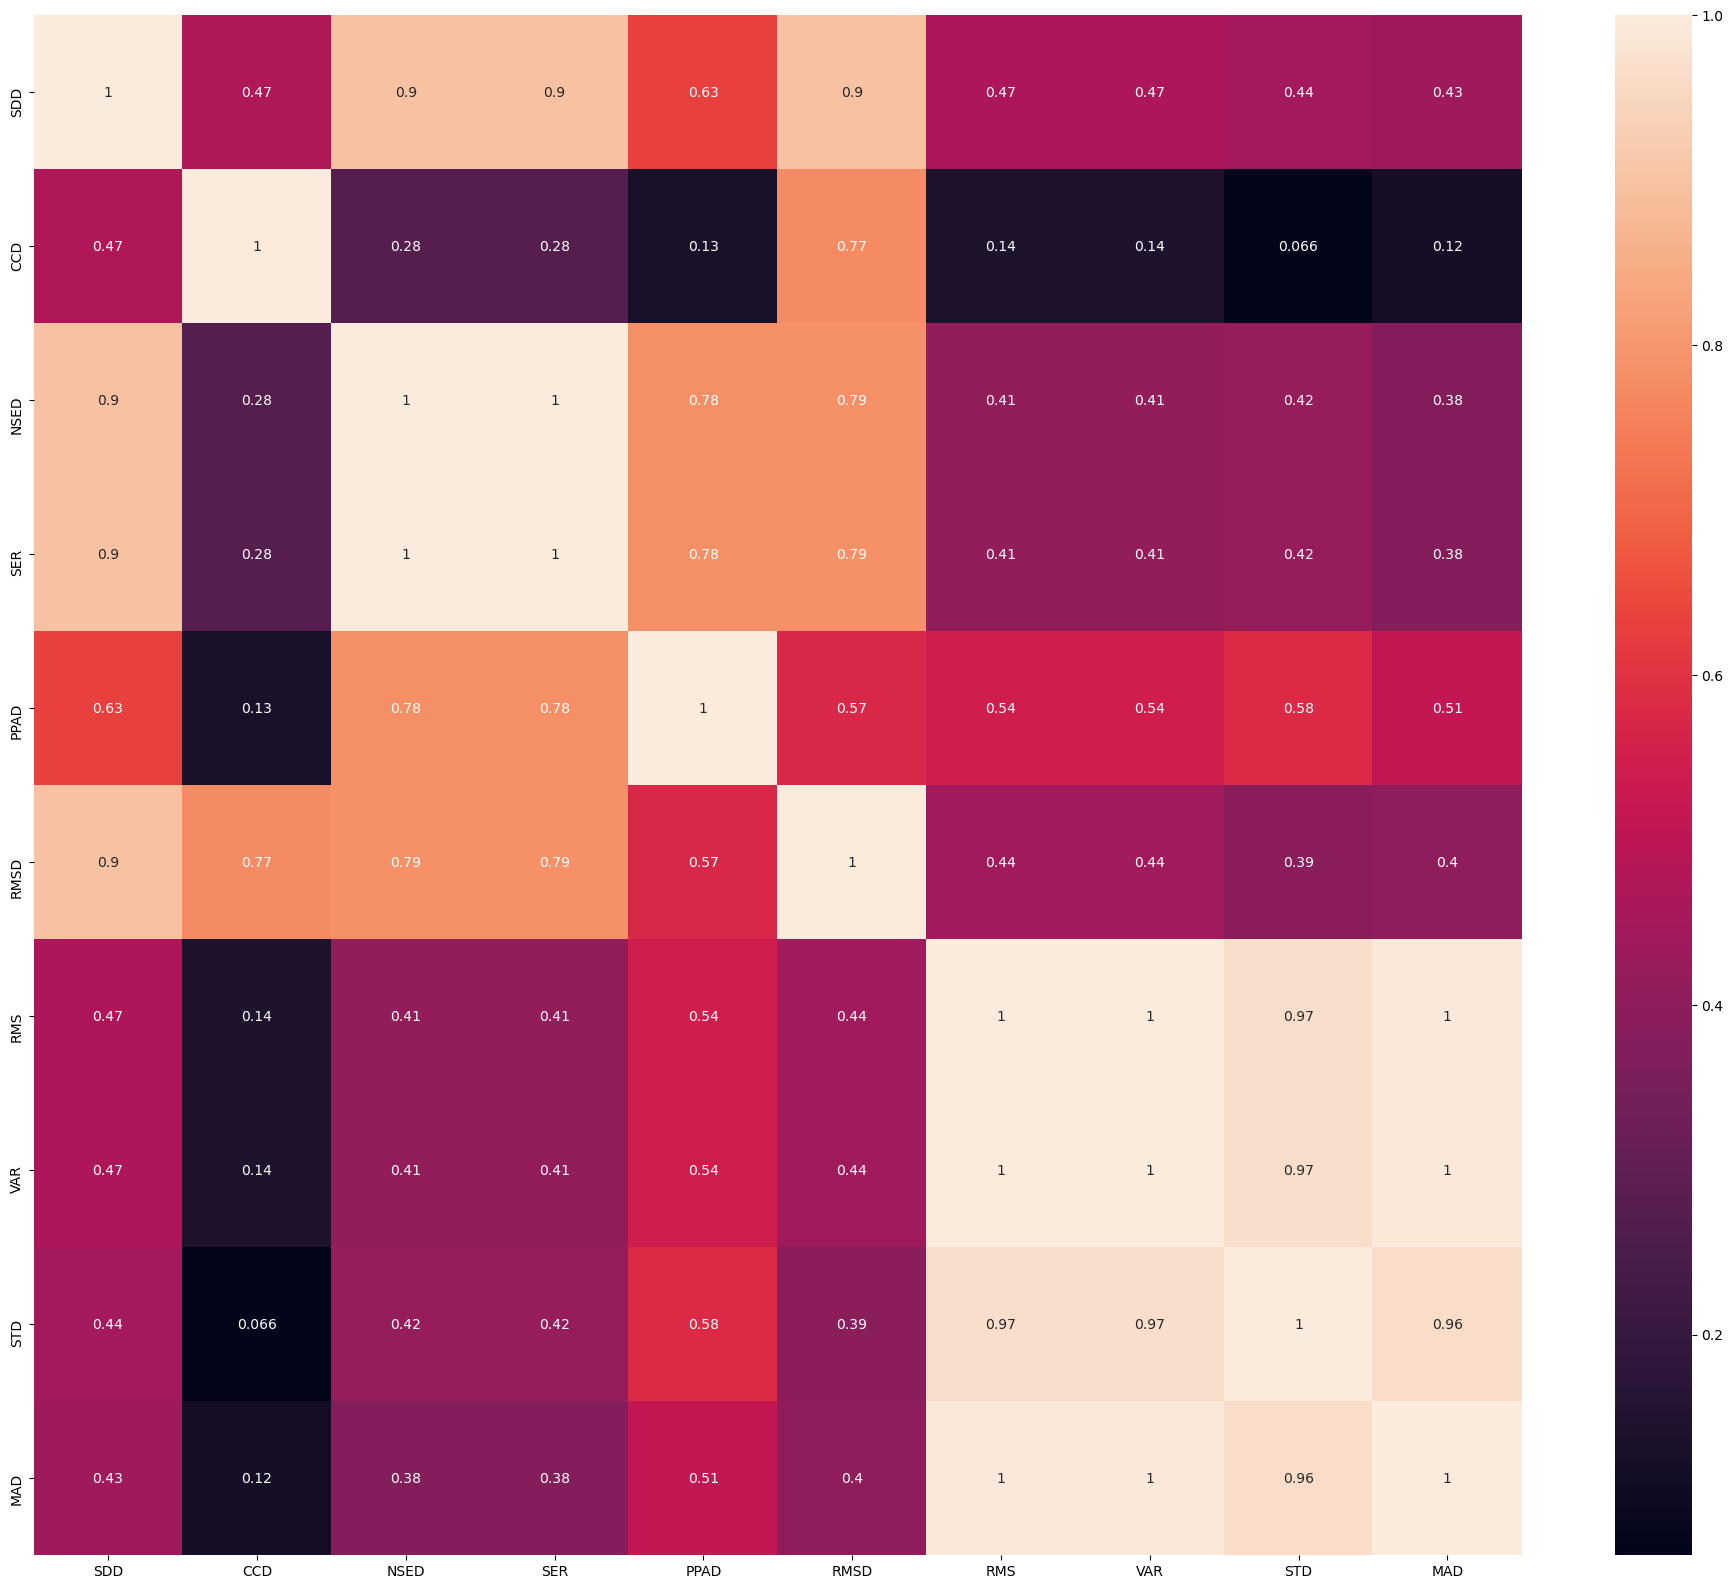

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#dropping correlated columns
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # threshold on absolute value as corr coefficients vary from -1 to 1
                colname = corr_matrix.columns[i]  # name of highly correlated column
                col_corr.add(colname) 
    return col_corr
    
#features with corr greater than threshold will be dropped
threshold = 0.95

#looking at correlation among various features
corrMatrix = df_features.corr(method='pearson')
fig,ax=plt.subplots(figsize=(24,20))
sns.heatmap(abs(corrMatrix),annot=True)
plt.show()

In [12]:
#dropping correlated columns
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
#             print(i,j)
#             print(corr_matrix.iloc[i, j])
            if abs(corr_matrix.iloc[i, j]) > threshold: # threshold on absolute value as corr coefficients vary from -1 to 1
                colname = corr_matrix.columns[i]  # name of highly correlated column
                col_corr.add(colname) 
    return col_corr

In [13]:
# print(f'Highly correlated features in dataset are {correlation(df_features, threshold )}')
df_refined_f = df_features.drop(correlation(df_features, threshold),axis=1)
# df_refined_f

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_refined_f, targets, test_size=0.25, random_state=142)

<ipython-input-15-e20c4fdb17e6>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


Accuracy is 1.0


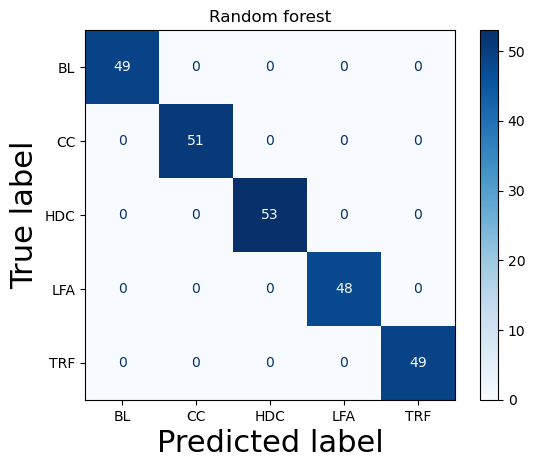

In [15]:
# permutation feature importance with knn for classification


rf = RandomForestClassifier()
# fit the rf
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred)
acc_linear = metrics.accuracy_score(y_test,y_pred)
print('Accuracy is',acc_linear)
# plot_confusion_matrix(rf, X_test, y_test,cmap='Blues',normalize='true')  
# plt.show()
labels = ["BL", "CC", "HDC", "LFA", "TRF"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt. grid(False) 
plt.title('Random forest')
plt.xlabel('Predicted label',fontsize = 22)
plt.ylabel('True label',fontsize = 22)
plt.rcParams.update({'font.size': 15})
plt.show()